In [40]:
# Add root directory to path
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.path.abspath('..'),
                  os.pardir)
)
sys.path.append(PROJECT_ROOT)

# Imports
from electronTransportCode.SimOptions import WaterPhantomSimulation
from electronTransportCode.SimulationDomain import SimulationDomain
from electronTransportCode.MCParticleTracer import AnalogParticleTracer, MCParticleTracer
from electronTransportCode.MCEstimator import DoseEstimator
from electronTransportCode.ProjectUtils import ERE
from electronTransportCode.ParticleModel import SimplifiedEGSnrcElectron
from electronTransportCode.ProjectUtils import E_THRESHOLD
from electronTransportCode.Material import Material
%matplotlib widget

In [41]:
# Set up initial conditions
eInit: float = 5.0/ERE  # 5 MeV initial energy
energyCutOff: float = E_THRESHOLD
SEED: int = 4  # Random number generator seed
xVariance: float = 0.1  # Variance on initial position in x and y direction
waterPhantomInit = WaterPhantomSimulation(minEnergy=energyCutOff, Esource=eInit, xVariance=xVariance, rngSeed=SEED)

In [42]:
# Set up simulation domain
from pyrfc3339 import generate


simDomain = SimulationDomain(-2.5, 7.5, -2.5, 7.5, 200, 200)

# Set up dose estimator
doseEstimator = DoseEstimator(simDomain=simDomain)

# Set up particle
particle = SimplifiedEGSnrcElectron(generator=SEED)  # rng is later overridden by simulation object 

# Set up particle tracer
particleTracer = AnalogParticleTracer(particle=particle, simOptions=waterPhantomInit, simDomain=simDomain)

### Plot Stopping power for sanity check

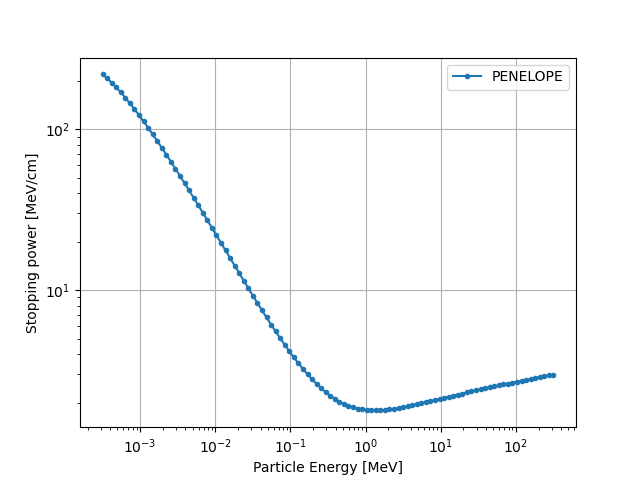

In [43]:
from electronTransportCode.Material import WaterMaterial
logrange = np.logspace(-3.5, 2.5, 100)  # MeV
stopping_power1 = np.array([particle.evalStoppingPower(E/ERE, WaterMaterial)*ERE for E in logrange])  # MeV/cm

plt.figure(1)
plt.loglog(logrange, stopping_power1, '.-', label='PENELOPE')
plt.xlabel('Particle Energy [MeV]')
plt.ylabel('Stopping power [MeV/cm]')
plt.legend()
plt.grid()

### Plot angular distribution 
The angular distribution is sharply peaked in the forward direction ($\mu = 0$)

In [50]:
from electronTransportCode.ProjectUtils import FSC, Re, ERE
def evalSRDCS(mu: float, Ekin: float, material: Material) -> float:
    ''' Evaluate screened rutherford elastic differential cross-section
    '''
    betaSquared: float = Ekin*(Ekin+2)/np.power(Ekin+1, 2)
    alfaPrime = FSC*material.Z/np.square(betaSquared)
    eta = material.eta0CONST*(1.13 + 3.76*np.power(alfaPrime, 2))
    
    return 2*np.pi*np.power(Re*material.Z, 2)/((betaSquared*Ekin*(Ekin+2))*(np.power(1-mu+2*eta, 2)))

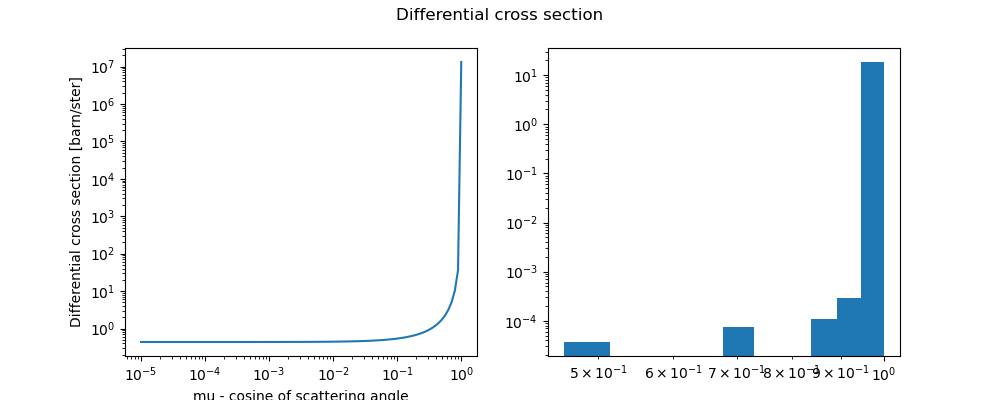

In [47]:
# Plot DCS
Ekin = 5.0/ERE  # 5.0 MeV
muArray = np.logspace(-5, 0, 100)
dcs = np.array([evalSRDCS(mu, Ekin, WaterMaterial) for mu in muArray])*1e24

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10 ,4))
fig.suptitle('Differential cross section')

ax1.loglog(muArray, dcs)
ax1.set_xlabel('mu - cosine of scattering angle')
ax1.set_ylabel('Differential cross section [barn/ster]')

# Sample angle
NbSamples = 500000
samples = np.array([particle.sampleAngle(Ekin, WaterMaterial) for _ in range(NbSamples)])
ax2.hist(samples, density=True, log=True)
ax2.set_xscale('log')

### Cross section

In [51]:
def evalSRCS(Ekin: float, material: Material) -> float:
    ''' Evaluate screened rutherford elastic cross-section
    '''
    betaSquared: float = Ekin*(Ekin+2)/np.power(Ekin+1, 2)
    alfaPrime = FSC*material.Z/np.square(betaSquared)
    eta = material.eta0CONST*(1.13 + 3.76*np.power(alfaPrime, 2))
    
    return np.pi*np.power(Re*material.Z, 2)/(betaSquared*Ekin*(Ekin+2)*(eta*(1+eta)))

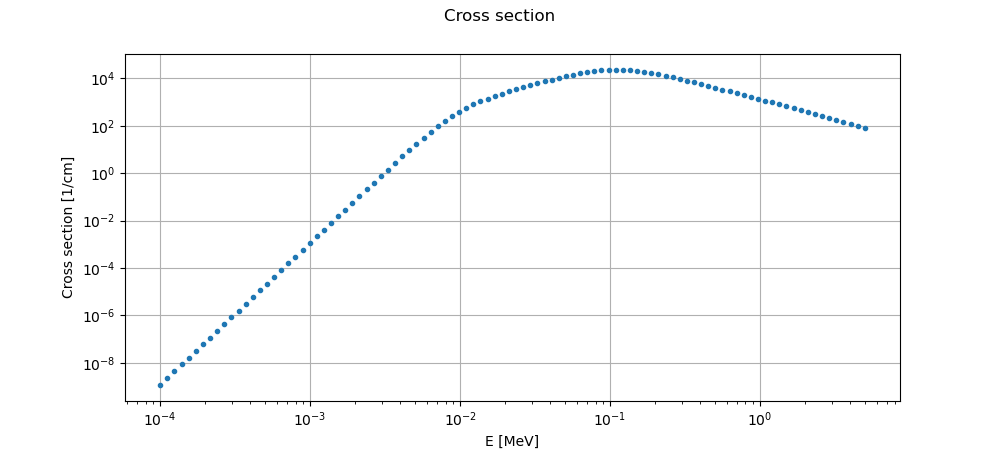

In [72]:
# Evaluate cross-section
Erange = np.logspace(-4, np.log10(5.0), 100)  # MeV
cs = np.fromiter((evalSRCS(E/ERE, WaterMaterial) for E in Erange), dtype=float)*WaterMaterial.NB_DENSITY

fig, ax1 = plt.subplots(figsize=(10, 4.5))
fig.suptitle('Cross section')

ax1.loglog(Erange, cs, '.')
ax1.set_xlabel('E [MeV]')
ax1.set_ylabel('Cross section [1/cm]')
ax1.grid()


### Do simulation

In [6]:
# Run simulation
NB_PARTICLES = 100
particleTracer(nbParticles=NB_PARTICLES, estimator=doseEstimator)
print(f'Average amount of events: {particleTracer.averageNbCollisions}')

faulty grid cell crossing
faulty grid cell crossing
faulty grid cell crossing
faulty grid cell crossing
faulty grid cell crossing
faulty grid cell crossing
faulty grid cell crossing
faulty grid cell crossing
faulty grid cell crossing
faulty grid cell crossing
faulty grid cell crossing
faulty grid cell crossing
faulty grid cell crossing
faulty grid cell crossing
faulty grid cell crossing
faulty grid cell crossing
faulty grid cell crossing
faulty grid cell crossing
faulty grid cell crossing
faulty grid cell crossing
faulty grid cell crossing
faulty grid cell crossing
faulty grid cell crossing
faulty grid cell crossing
Average amount of events: 29781.14


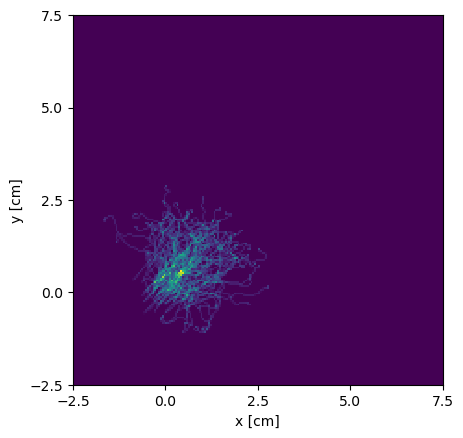

In [7]:
# Plot energy deposition
energyDeposition_ERE = np.reshape(doseEstimator.scoreMatrix, (simDomain.ybins, simDomain.xbins) )

fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.matshow(energyDeposition_ERE, extent=[-2.5, 7.5, -2.5, 7.5], origin='lower')
ax.set_xticks(np.linspace(-2.5, 7.5, 5))
ax.set_yticks(np.linspace(-2.5, 7.5, 5))
ax.xaxis.tick_bottom()
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
plt.show()

Text(0, 0.5, 'Energy deposition [1/ERE]')

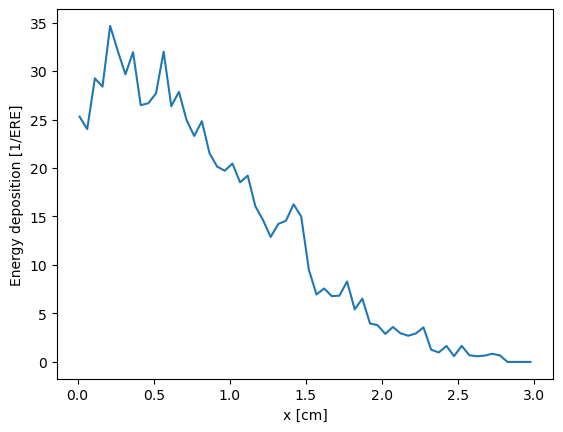

In [8]:
xEnergyDeposition_ERE = energyDeposition_ERE.sum(axis=0)
startIndex = 50
endIndex = 110
x = np.linspace(-2.5, 7.5, 200)
fig, ax = plt.subplots()
ax.plot(x[startIndex:endIndex], xEnergyDeposition_ERE[startIndex:endIndex])
ax.set_xlabel('x [cm]')
ax.set_ylabel('Energy deposition [1/ERE]')